# Tokenization

In [1]:
import pandas as pd
from soynlp.hangle import decompose, character_is_korean

In [ ]:
# https://github.com/ratsgo/embedding/blob/e7f716714d466c03faf1ed3b245f2fc773c04caf/preprocess/unsupervised_nlputils.py#L120
# https://lovit.github.io/nlp/representation/2018/10/22/fasttext_subword/

def decompose_into_jamo(sentence):
    doublespace_pattern = re.compile('\s+')
    
    def transform(char):
        if char == ' ':
            return char
        cjj = decompose(char)
        if len(cjj) == 1:
            return cjj
        cjj_ = ''.join(c if c != ' ' else '-' for c in cjj)
        return cjj_

    result = []
    for char in sentence:
        if character_is_korean(char):
            result.append(transform(char))
        else:
            result.append(char)
    result = doublespace_pattern.sub(' ', ''.join(result))
    return result

### Ambiguity

- Proper nouns are one of the parts of speech where a lot of new words appears
- One of the main motivations for adjusting the priority is to disambiguate new vocabulary
- E.g., 걔는 비를 좋아한다 (She likes 비) → 비? 🧑‍🎤? 아니면 🌧️?
- If it’s difficult to estimate the appropriate cost, default dictionary in mecab-ko-dic might be helpful
- There are lots of homonyms in the default dictionary and it relieves the ambiguity by assigning a high cost to vobaculary to less used ones
- One-letter vocabulary in `Person.csv` and `Person-actor.csv` provided by mecab-ko-dic have much higher proportion of homonyms than the vocabulary that doesn’t
- And a trend of its cost also significantly different

In [2]:
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar zxfv mecab-ko-dic-2.1.1-20180720.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 47.4M  100 47.4M    0     0  8002k      0  0:00:06  0:00:06 --:--:-- 11.9MM   66 31.6M    0     0  6364k      0  0:00:07  0:00:05  0:00:02 8299k
mecab-ko-dic-2.1.1-20180720/
mecab-ko-dic-2.1.1-20180720/configure
mecab-ko-dic-2.1.1-20180720/COPYING
mecab-ko-dic-2.1.1-20180720/autogen.sh
mecab-ko-dic-2.1.1-20180720/Place-station.csv
mecab-ko-dic-2.1.1-20180720/NNG.csv
mecab-ko-dic-2.1.1-20180720/README
mecab-ko-dic-2.1.1-20180720/EF.csv
mecab-ko-dic-2.1.1-20180720/MAG.csv
mecab-ko-dic-2.1.1-20180720/Preanalysis.csv
mecab-ko-dic-2.1.1-20180720/NNB.csv
mecab-ko-dic-2.1.1-20180720/Person-actor.csv
mecab-ko-dic-2.1.1-20180720/VV.csv
mecab-ko-dic-2.1.1-20180720/Makefile.in
mecab-ko-dic-2.1.1-20180720/matrix.def
mecab-ko-dic-2.1.1-20180720/EC.csv
mecab-ko-d

In [3]:
mecab_people = pd.read_csv(
    'mecab-ko-dic-2.1.1-20180720/Person.csv', 
    header=None, 
    names=[
        '표층형', 'left-ID', 'right-ID', '비용', 
        '품사', '의미 부류', '종성 유무', '읽기',
        '타입', '첫번째 품사', '마지막 품사', '표현'
    ]
)

mecab_people = pd.concat((
    mecab_people, 
    pd.read_csv(
        'mecab-ko-dic-2.1.1-20180720/Person-actor.csv', 
        header=None, 
        names=[
            '표층형', 'left-ID', 'right-ID', '비용', 
            '품사', '의미 부류', '종성 유무', '읽기', 
            '타입', '첫번째 품사', '마지막 품사', '표현'
        ]
    )
))

<AxesSubplot:ylabel='Frequency'>

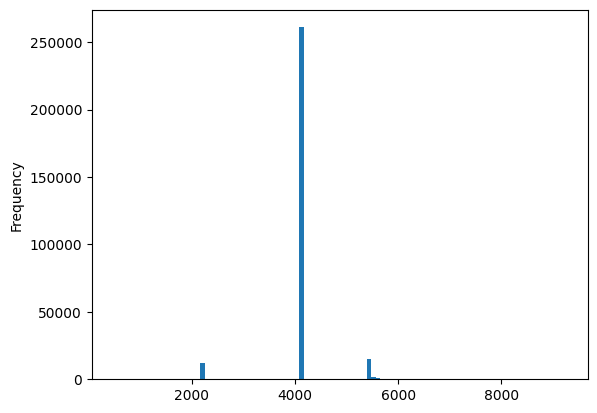

In [4]:
mecab_people['비용'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

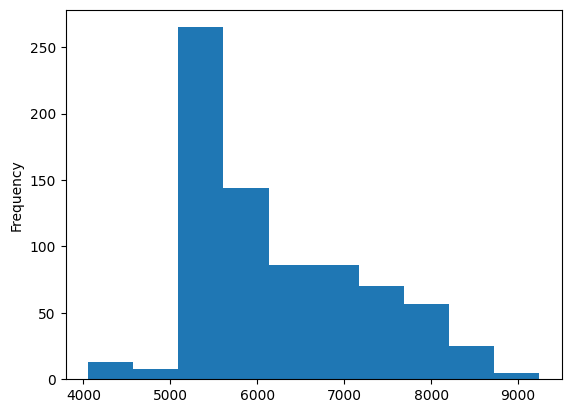

In [5]:
mecab_people[mecab_people['표층형'].str.len() == 1]['비용'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

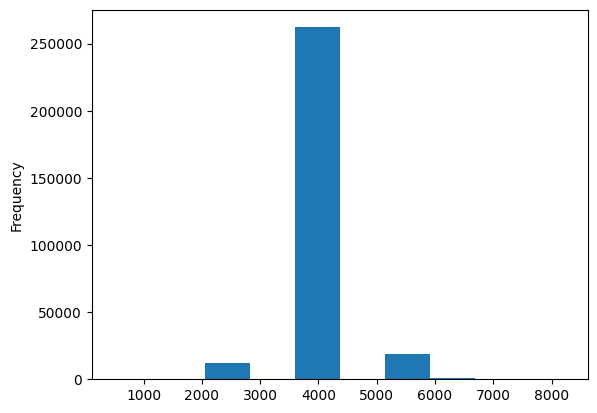

In [6]:
mecab_people[mecab_people['표층형'].str.len() >= 2]['비용'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

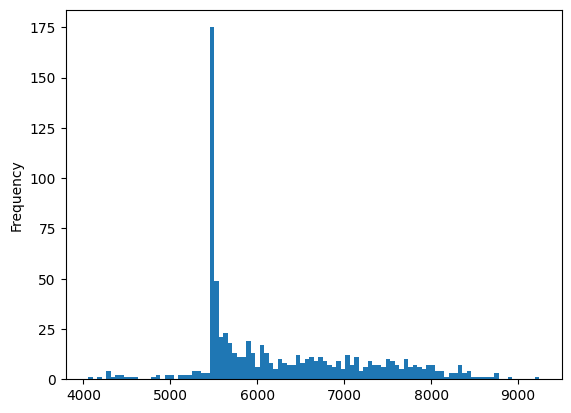

In [7]:
mecab_people[mecab_people['표층형'].str.len() == 1]['비용'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

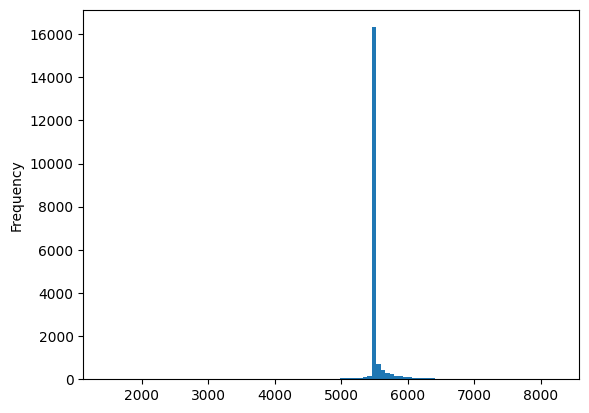

In [8]:
mecab_people[mecab_people['표층형'].str.len() == 2]['비용'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

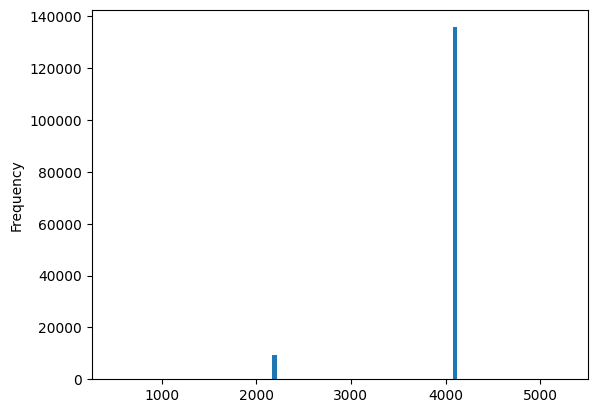

In [9]:
mecab_people[mecab_people['표층형'].str.len() == 3]['비용'].plot.hist(bins=100)

### Named Entity Normalization: person name

- Proper nouns are one of the parts of speech where a lot of new words appears
- E.g., person name, movie title, ...
- That's why I implemented the normalization below
- However, there is a lot of words with strong ambiguity in the person name dictionary provided by default in MeCab
- E.g., `레이디`, `가가`, ...
- So it may be more appropriate to remove the default person name dictionary and build a new one ourselves in terms of disambiguation if we can obtain a list of people names
- E.g., f1(val) w/ NEN is 0.850 and w/o is 0.852
- And `인명` may be too general to be used for normalization
- So it may be appropriate to normalize by their jobs or other characteristics

In [10]:
def normalize_and_parse(x):
    morphemes = mecab.parse(x)
    result = x
    
    for idx, morpheme in enumerate(morphemes):
        if morpheme[1].semantic != '인명': continue        
        result = result.replace(
            morpheme[0], 
            '사람', 
            1
        )
        
    result = ' '.join(mecab.morphs(result))
        
    return result

def tokenize(documents):
    return documents.parallel_apply(
        lambda x: normalize_and_parse(x)
    )